In [10]:
import numpy as np
import pandas as pd
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from mlxtend.preprocessing import TransactionEncoder

In [10]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('punkt_tab')

In [11]:
speech_file = 'C:/Users/Cecil/OneDrive/Skrivebord/speeches_114.txt'  # Contains speech_id and speech columns
speaker_file = 'C:/Users/Cecil/OneDrive/Skrivebord/114_SpeakerMap.txt'  # Contains speaker metadata
# Load Speech File
with open(speech_file, 'r') as f:
    speeches = []
    for line in f:
        speech_id, speech = line.strip().split('|', 1)
        speeches.append({'speech_id': speech_id, 'speech': speech})

speech_df = pd.DataFrame(speeches)

# Load Speaker Metadata File
with open(speaker_file, 'r') as f:
    speakers = []
    for line in f:
        fields = line.strip().split('|')
        speakers.append({
            'speakerid': fields[0],
            'speech_id': fields[1],
            'lastname': fields[2],
            'firstname': fields[3],
            'chamber': fields[4],
            'state': fields[5],
            'gender': fields[6],
            'party': fields[7],
            'district': fields[8],
            'nonvoting': fields[9]
        })

speaker_df = pd.DataFrame(speakers)

# Merge datasets on speech_id
merged_data = pd.merge(speaker_df, speech_df, on='speech_id', how='left')
merged_data = merged_data[~((merged_data['firstname'] == 'MITCH') & (merged_data['lastname'] == 'MCCONNELL'))]
merged_data = merged_data.drop(index=0).reset_index(drop=True)


Der er færre speakers i speaker filen end der er i speeches der snakker. Der er 67971 personer i speakers

In [12]:
print(len(speech_df['speech_id'].unique()))
print(len(speaker_df['speech_id'].unique()))
print(merged_data['chamber'].unique)


112291
67972
<bound method Series.unique of 0        H
1        H
2        H
3        H
4        H
        ..
64751    H
64752    H
64753    S
64754    H
64755    H
Name: chamber, Length: 64756, dtype: object>


In [13]:
nltk.data.path.append('C:/Users/Cecil/AppData/Roaming/nltk_data/tokenizers')
stop_words = set(stopwords.words('english'))
stop_words2 = ['president', 'speaker', 'us', 'we', 'are', 'would', 'today', 'chairman', 'ask', 'unanimous', 'people', 'time', 'madam', 'clerk', 'office', 'house', 'representatives', 'member', 'states', 'present', 'honor', 'united', 'election', 'congress', 'name', 'honorable', 'colleagues', 'judge', 'one', 'first', 'like', 'recognize', 'every', 'taken', 'floor', 'welcome', 'bill','legislation', 'going', 'senate', 'make', 'also', 'want', 'act', 'dont', 'get', 'law', 'court', 'supreme', 'american', 'amendment', 'senator','years', 'committee','state','support','many', 'know', 'now']

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lower case
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in stop_words2]  # Remove stopwords
    return tokens


In [14]:
merged_data['processed_speech'] = merged_data['speech'].apply(preprocess_text)
# Output the first few rows to check the result
print(merged_data.head())

   speakerid   speech_id          lastname firstname chamber state gender  \
0  114120480  1140000007  MCMORRIS RODGERS     CATHY       H    WA      F   
1  114118560  1140000009           BECERRA    XAVIER       H    CA      M   
2  114121890  1140000011            MASSIE    THOMAS       H    KY      M   
3  114122500  1140000013       BRIDENSTINE       JIM       H    OK      M   
4  114120780  1140000017            PELOSI     NANCY       H    CA      F   

  party district nonvoting                                             speech  \
0     R        5    voting  RODGERS. Madam Clerk. it is an honor to addres...   
1     D       34    voting  Madam Clerk. first I would like to recognize e...   
2     R        4    voting  Madam Clerk. I present for election to the off...   
3     R        1    voting  Madam Clerk. I present for the election of the...   
4     D       12    voting  My colleagues of the United States House of Re...   

                                    processed_spee

In [16]:
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
republicans_data = merged_data[merged_data['party'] == 'R']
democrats_data = merged_data[merged_data['party'] == 'D']

# Function to extract item pairs from speeches
def extract_item_pairs_from_speech(speech_tokens, min_length=2):
    item_pairs = []
    if len(speech_tokens) >= min_length:
        # Generate combinations of item pairs
        item_pairs.extend(combinations(sorted(speech_tokens), 2))
    return item_pairs

# Function to count item pairs for a party
def count_item_pairs_by_party(data):
    pair_counts = defaultdict(int)  # Use defaultdict to automatically handle missing keys
    
    for _, row in data.iterrows():
        items = row['processed_speech']  # List of tokens (words) from the speech
        pairs = extract_item_pairs_from_speech(items)
        for pair in pairs:
            pair_counts[pair] += 1  # Increment count for each item pair
            
    return pair_counts

# For Republicans
republican_item_pairs = count_item_pairs_by_party(republicans_data)
# For Democrats
democrat_item_pairs = count_item_pairs_by_party(democrats_data)

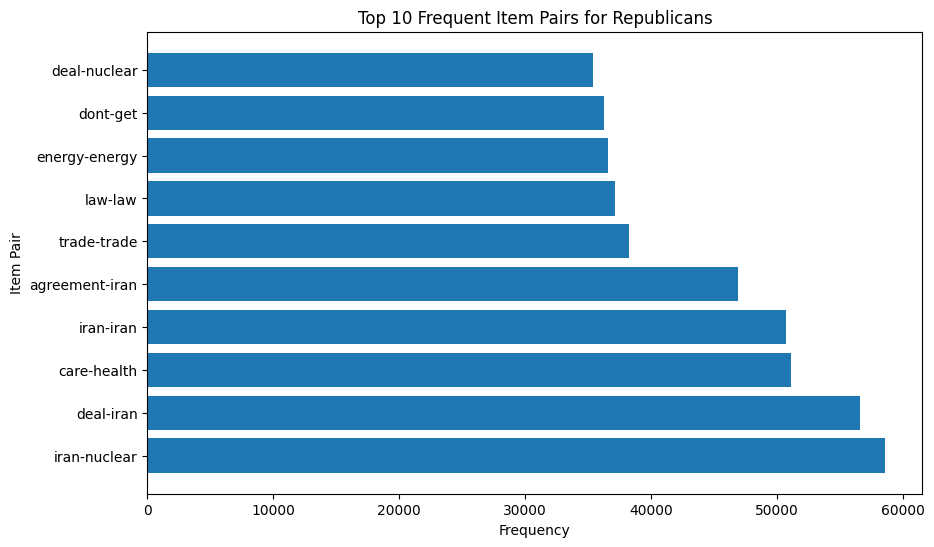

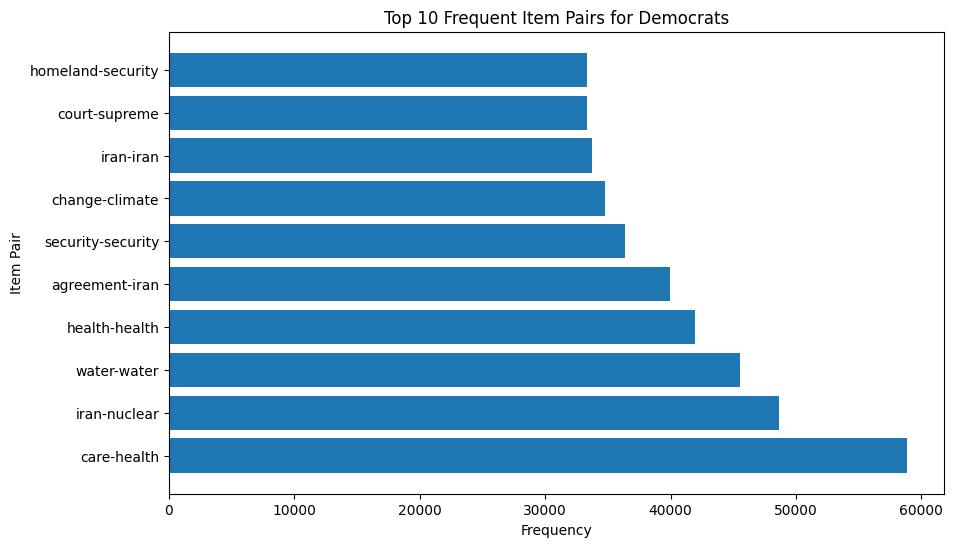

In [17]:

# Convert the dictionary to a DataFrame to facilitate sorting and visualization
republican_item_pairs_df = pd.DataFrame(republican_item_pairs.items(), columns=['item_pair', 'frequency'])
democrat_item_pairs_df = pd.DataFrame(democrat_item_pairs.items(), columns=['item_pair', 'frequency'])

# Sort the item pairs by frequency in descending order and take the top 10
top_republican_item_pairs = republican_item_pairs_df.sort_values('frequency', ascending=False).head(10)
top_democrat_item_pairs = democrat_item_pairs_df.sort_values('frequency', ascending=False).head(10)

# Plot the top 10 frequent item pairs for Republicans
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_republican_item_pairs)), top_republican_item_pairs['frequency'], 
         tick_label=[f'{pair[0]}-{pair[1]}' for pair in top_republican_item_pairs['item_pair']])
plt.xlabel('Frequency')
plt.ylabel('Item Pair')
plt.title('Top 10 Frequent Item Pairs for Republicans')
plt.show()

# Plot the top 10 frequent item pairs for Democrats
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_democrat_item_pairs)), top_democrat_item_pairs['frequency'], 
         tick_label=[f'{pair[0]}-{pair[1]}' for pair in top_democrat_item_pairs['item_pair']])
plt.xlabel('Frequency')
plt.ylabel('Item Pair')
plt.title('Top 10 Frequent Item Pairs for Democrats')
plt.show()


In [ ]:
import numpy as np
from collections import defaultdict
from itertools import combinations
republicans_data = merged_data[merged_data['party'] == 'R']
democrats_data = merged_data[merged_data['party'] == 'D']
def pcy_algorithm(data, min_support, num_buckets=100):
    single_counts = defaultdict(int)
    bucket_counts = np.zeros(num_buckets, dtype=int)
    
    # First pass: Count individual items and hash buckets for pairs
    for _, row in data.iterrows():
        items = row['processed_speech']
        for item in items:
            single_counts[item] += 1
        for pair in combinations(items, 2):
            # Ensure the two items in the pair are not the same
            if pair[0] != pair[1]:
                bucket_index = hash(pair) % num_buckets
                bucket_counts[bucket_index] += 1
    
    # Identify frequent items and buckets
    frequent_items = {item for item, count in single_counts.items() if count >= min_support}
    frequent_buckets = {i for i, count in enumerate(bucket_counts) if count >= min_support}
    
    # Second pass: Count frequent pairs using filtered buckets
    pair_counts = defaultdict(int)
    for _, row in data.iterrows():
        items = row['processed_speech']
        for pair in combinations(items, 2):
            # Ensure the two items in the pair are not the same
            if pair[0] != pair[1] and pair[0] in frequent_items and pair[1] in frequent_items:
                bucket_index = hash(pair) % num_buckets
                if bucket_index in frequent_buckets:
                    pair_counts[pair] += 1
    
    # Filter pairs by min_support
    frequent_pairs = {pair: count for pair, count in pair_counts.items() if count >= min_support}
    
    return frequent_items, frequent_pairs, single_counts

# Apply PCY to your dataset
min_support = 75
republican_frequent_items, republican_frequent_pairs, republican_single_counts = pcy_algorithm(republicans_data, min_support)
democrat_frequent_items, democrat_frequent_pairs, democrat_single_counts = pcy_algorithm(democrats_data, min_support)

# Sort frequent items and pairs by their counts
sorted_republican_items = sorted(list(republican_frequent_items), key=lambda x: republican_single_counts.get(x, 0), reverse=True)
sorted_republican_pairs = sorted(republican_frequent_pairs.items(), key=lambda x: x[1], reverse=True)

# Sort frequent items and pairs by their counts
sorted_democrat_items = sorted(list(democrat_frequent_items), key=lambda x: democrat_single_counts.get(x, 0), reverse=True)
sorted_democrat_pairs = sorted(democrat_frequent_pairs.items(), key=lambda x: x[1], reverse=True)


In [ ]:
# Print top 10 frequent items and pairs
print("Top 10 Frequent Items (Democrats):")
for item in sorted_democrat_items[:10]:
    print(f"Item: {item}, Support Count: {democrat_single_counts[item]}")

print("\nTop 10 Frequent Pairs (Democrats):")
for pair, count in sorted_democrat_pairs[:10]:
    print(f"Pair: {pair}, Support Count: {count}")

# Print top 10 frequent items and pairs
print("\nTop 10 Frequent Items (Republicans):")
for item in sorted_republican_items[:10]:
    print(f"Item: {item}, Support Count: {republican_single_counts[item]}")

print("\nTop 10 Frequent Pairs (Republicans):")
for pair, count in sorted_republican_pairs[:10]:
    print(f"Pair: {pair}, Support Count: {count}")



Top 10 Frequent Items (Democrats):
Item: amendment, Support Count: 15440
Item: years, Support Count: 14048
Item: american, Support Count: 13494
Item: country, Support Count: 13257
Item: work, Support Count: 13026
Item: many, Support Count: 12641
Item: support, Support Count: 12381
Item: senator, Support Count: 11829
Item: know, Support Count: 11662
Item: need, Support Count: 11658

Top 10 Frequent Pairs (Democrats):
Pair: ('water', 'water'), Support Count: 45547
Pair: ('health', 'health'), Support Count: 41958
Pair: ('security', 'security'), Support Count: 36331
Pair: ('iran', 'iran'), Support Count: 33749
Pair: ('health', 'care'), Support Count: 31867
Pair: ('care', 'care'), Support Count: 31332
Pair: ('budget', 'budget'), Support Count: 29836
Pair: ('trade', 'trade'), Support Count: 29008
Pair: ('senator', 'senator'), Support Count: 28205
Pair: ('energy', 'energy'), Support Count: 27898

Top 10 Frequent Items (Republicans):
Item: amendment, Support Count: 16564
Item: years, Support C

# Plots

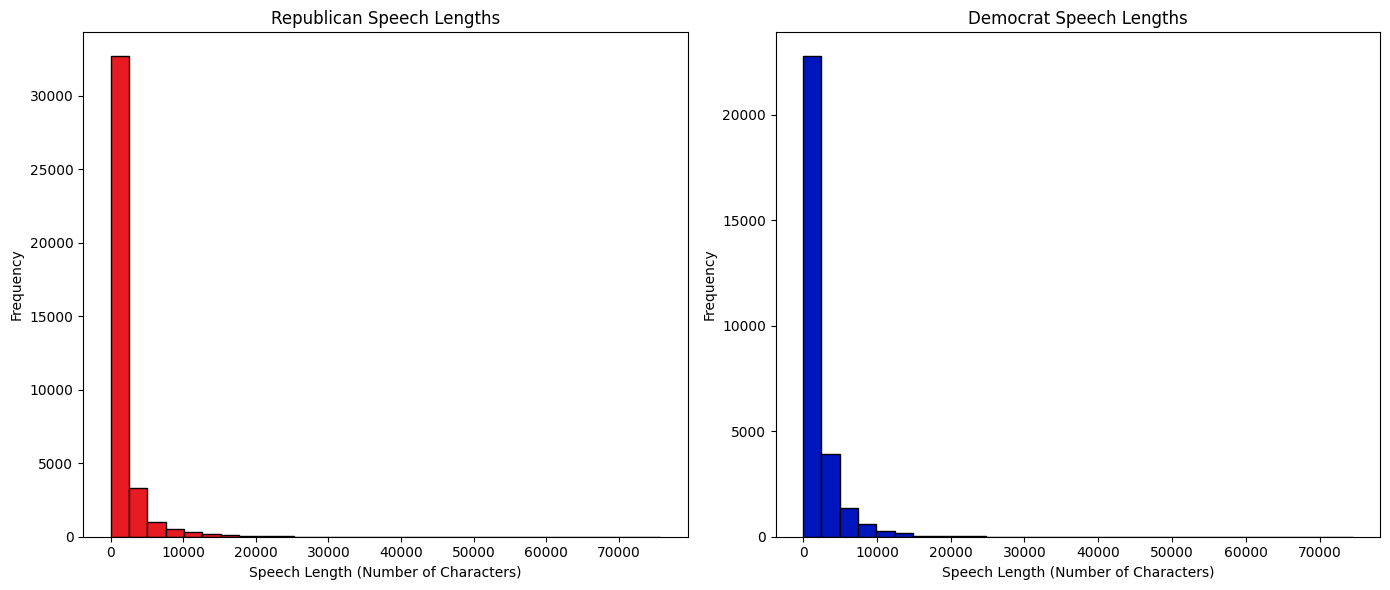

In [20]:
# Calculate the speech length (number of characters)
merged_data['speech_length'] = merged_data['speech'].apply(len)

# Split the data by party
republicans = merged_data[merged_data['party'] == 'R']
democrats = merged_data[merged_data['party'] == 'D']

# Create two subplots: one for Republicans and one for Democrats
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Republican speeches histogram
axes[0].hist(republicans['speech_length'], bins=30, color='#E81B23', edgecolor='black')
axes[0].set_title('Republican Speech Lengths')
axes[0].set_xlabel('Speech Length (Number of Characters)')
axes[0].set_ylabel('Frequency')

# Democrat speeches histogram
axes[1].hist(democrats['speech_length'], bins=30, color='#0015BC', edgecolor='black')
axes[1].set_title('Democrat Speech Lengths')
axes[1].set_xlabel('Speech Length (Number of Characters)')
axes[1].set_ylabel('Frequency')

# Display the plot
plt.tight_layout()  # Adjust spacing between subplots
plt.show()


C:\Users\Cecil\AppData\Local\Temp\ipykernel_35344\1284893230.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=party_counts.index, y=party_counts.values, palette=party_palette)


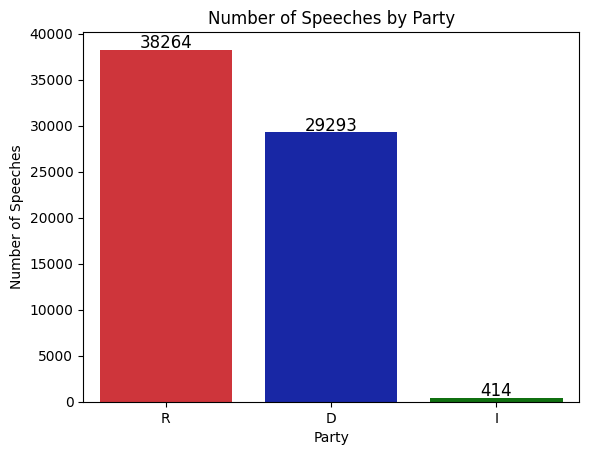

In [21]:
# Count number of speeches per party
party_counts = merged_data['party'].value_counts()

# Define custom colors for the parties
party_palette = {'R': '#E81B23', 'D': '#0015BC', 'I': 'green'}
# Create the bar chart
ax = sns.barplot(x=party_counts.index, y=party_counts.values, palette=party_palette)

# Add counts on top of each bar
for p in ax.patches:
    # Add the count label on top of each bar
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', fontweight='normal', 
                xytext=(0, 5), textcoords='offset points')

# Customize the chart
plt.title('Number of Speeches by Party')
plt.xlabel('Party')
plt.ylabel('Number of Speeches')

# Show the plot
plt.show()

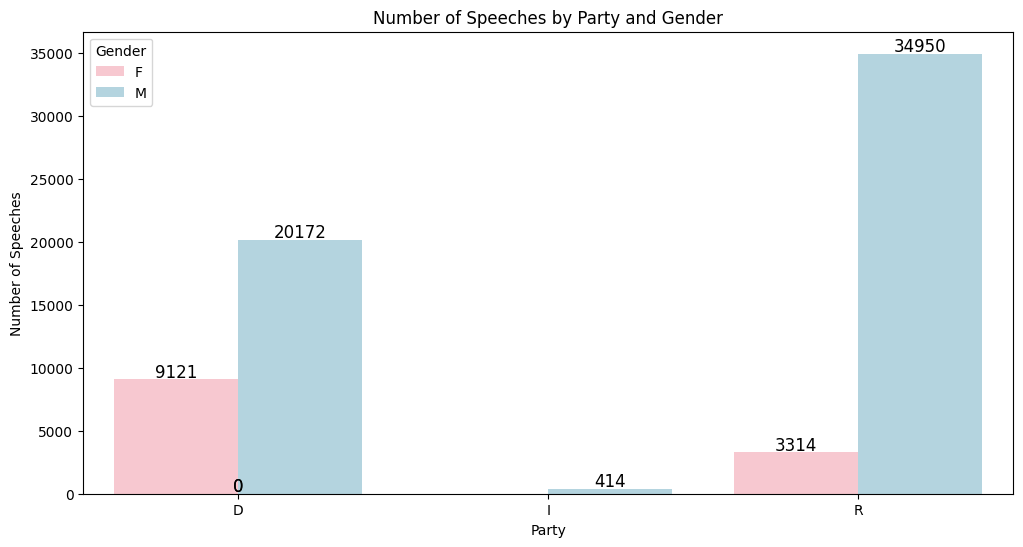

In [22]:
# Check unique values in 'gender' to confirm the values
party_gender_counts = merged_data.groupby(['party', 'gender']).size().reset_index(name='speech_count')

# Define custom color palettes for both party and gender
party_palette = {'R': '#E81B23', 'D': '#0015BC'}  # Republican and Democrat colors
gender_palette = {'M': 'lightblue', 'F': 'pink'}  # Male and Female gender colors

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the bar chart
ax = sns.barplot(data=party_gender_counts, x='party', y='speech_count', hue='gender', 
                 dodge=True,  # This makes sure the bars for each gender are separate within each party
                 palette=gender_palette)

# Add counts on top of each bar
for p in ax.patches:
    # Add the count label on top of each bar
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', fontweight='normal', 
                xytext=(0, 5), textcoords='offset points')

# Customize the chart
plt.title('Number of Speeches by Party and Gender')
plt.xlabel('Party')
plt.ylabel('Number of Speeches')
plt.legend(title='Gender')

# Show the plot
plt.show()


C:\Users\Cecil\AppData\Local\Temp\ipykernel_35344\3026564818.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_speakers.values, y=top_speakers.index, palette=colors)


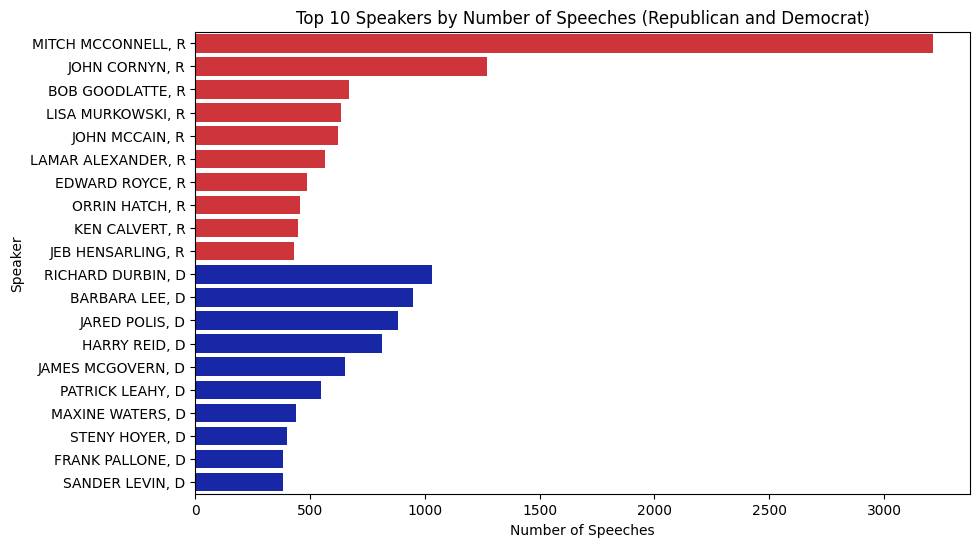

In [23]:

# Filter data for Republicans and Democrats
republicans = merged_data[merged_data['party'] == 'R']
democrats = merged_data[merged_data['party'] == 'D']

# Count number of speeches per speaker for each party
republican_speaker_counts = (republicans['firstname'] + " " + republicans['lastname'] + ", R").value_counts().head(10)
democrat_speaker_counts = (democrats['firstname'] + " " + democrats['lastname']+ ", D").value_counts().head(10)

# Combine top 10 speakers from both parties using pd.concat
top_speakers = pd.concat([republican_speaker_counts, democrat_speaker_counts])

# Create a list of colors based on party
colors = []
for speaker in top_speakers.index:
    # Check the party of the speaker from the 'party' column
    if speaker.split(" ")[-1] == 'R':  # If last name has the Republican party info
        colors.append('#E81B23')  # Republican color
    elif speaker.split(" ")[-1] == 'D':  # If last name has the Democrat party info
        colors.append('#0015BC')  # Democrat color
    else:
        colors.append('#8A8A8A')  # Default color for others

# Plot bar chart with custom colors
plt.figure(figsize=(10, 6))
sns.barplot(x=top_speakers.values, y=top_speakers.index, palette=colors)
plt.title('Top 10 Speakers by Number of Speeches (Republican and Democrat)')
plt.xlabel('Number of Speeches')
plt.ylabel('Speaker')
plt.show()

Positive Sentiment: If the polarity score is close to 1, the text is considered to have a positive sentiment. For example, a sentence like "I am happy" would have a positive polarity.

Neutral Sentiment: If the polarity score is close to 0, the text is considered neutral. This could mean the text is objective or lacks emotional expression.

Negative Sentiment: If the polarity score is close to -1, the text is considered negative. For example, a sentence like "I am sad" would have a negative polarity.

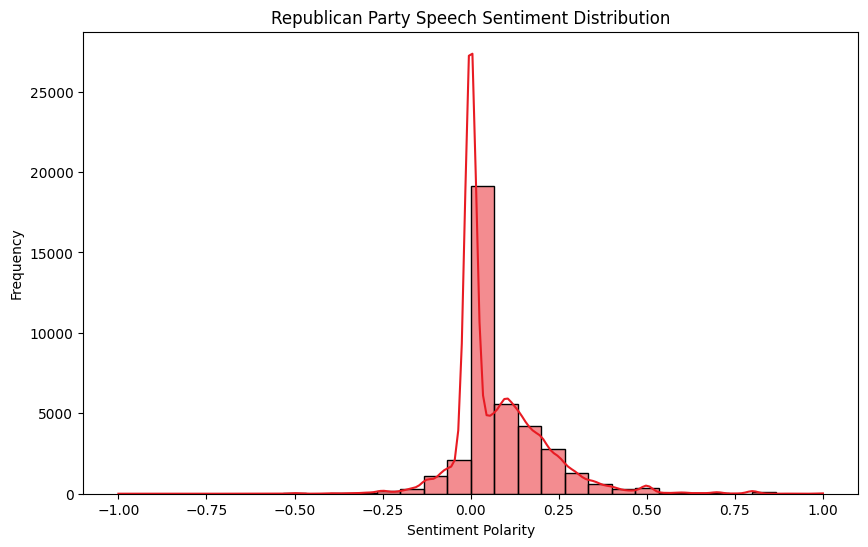

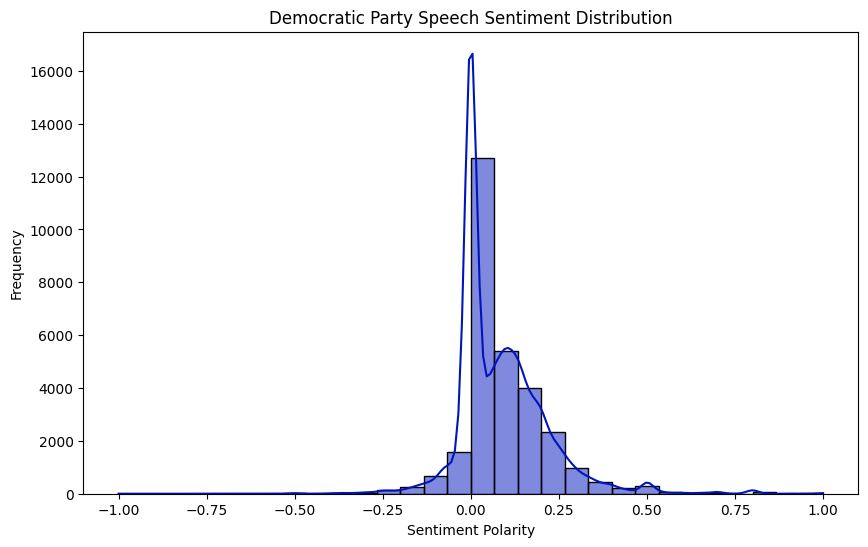

In [24]:
# Function to get sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment function to the speech column
merged_data['sentiment'] = merged_data['speech'].apply(get_sentiment)

# Filter data by party
party_r = merged_data[merged_data['party'] == 'R']
party_d = merged_data[merged_data['party'] == 'D']

# Plot sentiment distribution for Republicans (using custom color #E81B23)
plt.figure(figsize=(10, 6))
sns.histplot(party_r['sentiment'], bins=30, kde=True, color='#E81B23')  # Republican color
plt.title('Republican Party Speech Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Plot sentiment distribution for Democrats (using custom color #0015BC)
plt.figure(figsize=(10, 6))
sns.histplot(party_d['sentiment'], bins=30, kde=True, color='#0015BC')  # Democrat color
plt.title('Democratic Party Speech Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

C:\Users\Cecil\AppData\Local\Temp\ipykernel_35344\1545303417.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette='coolwarm')


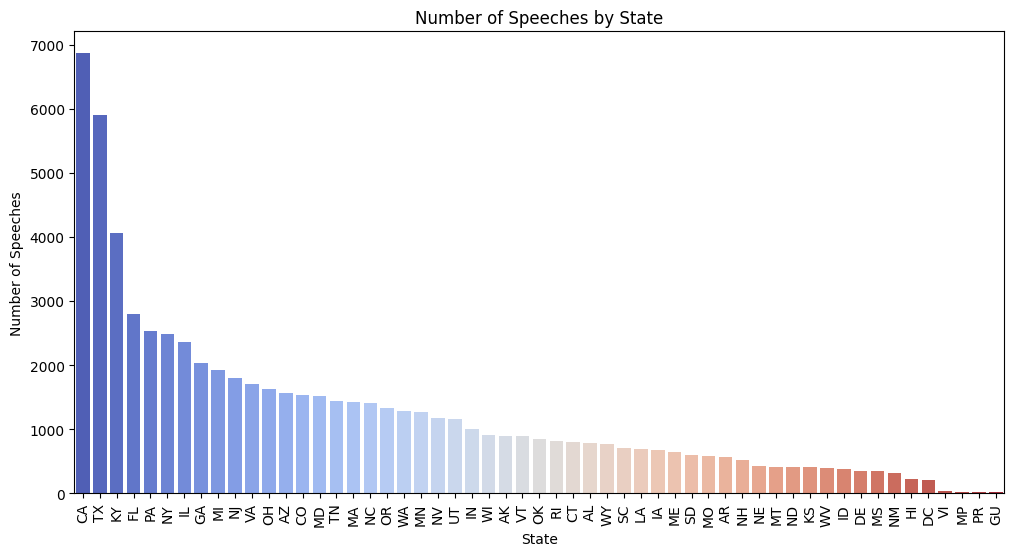

In [25]:
# Count the number of speeches per state
state_counts = merged_data['state'].value_counts()

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='coolwarm')
plt.title('Number of Speeches by State')
plt.xlabel('State')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=90)
plt.show()
